# Underlying Price Distribution From Options Prices

## Environment setup and imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

## Utility Functions

In [40]:
def discrete_expectation(f, dist):
    outputs = f(dist["x"].values) * dist["pdf"].values
    average_outputs = (outputs[:-1] + outputs[1:]) / 2
    dx = dist["x"][1:].values - dist["x"][:-1].values
    return (average_outputs * dx).sum()

In [114]:
def create_normal_distribution(mu=0, sigma=1, max_x=100, N=1000):
    pdf = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))
    x_range = np.linspace(-max_x, max_x, N)
    dist = pd.DataFrame({
        "x": x_range,
        "pdf": pdf(x_range)
    })
    return dist

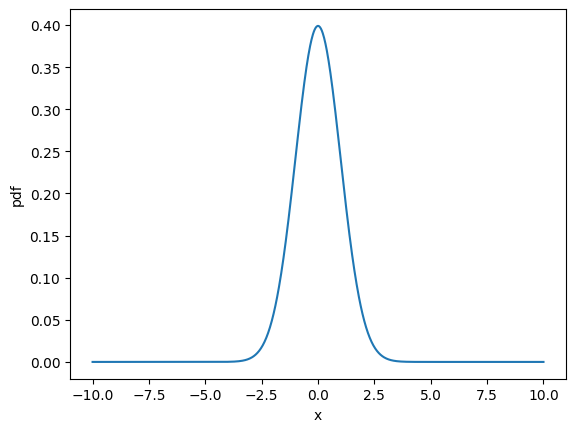

In [150]:
dist = create_normal_distribution(0, 1, max_x=10)
plt.xlabel("x")
plt.ylabel("pdf")
plt.plot(dist["x"], dist["pdf"])
plt.show()

In [151]:
norm = discrete_expectation(np.vectorize(lambda x: 1), dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 0.0
Variance: 1.0


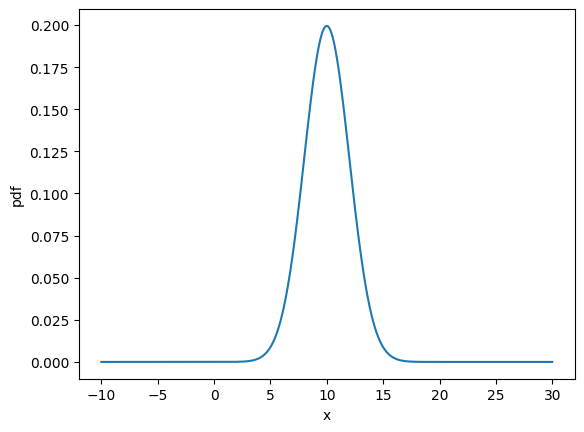

In [161]:
n_dist = dist.copy()
n_mu = 10
n_sigma = 2
n_dist["x"] = n_dist["x"] * n_sigma + n_mu
n_dist["pdf"] = n_dist["pdf"] / n_sigma

plt.xlabel("x")
plt.ylabel("pdf")
plt.plot(n_dist["x"], n_dist["pdf"])
plt.show()

In [162]:
norm = discrete_expectation(np.vectorize(lambda x: 1), n_dist)
print("Normalization:", norm)

expectation = discrete_expectation(lambda x: x, n_dist)
print("Expectation:", expectation)

variance = discrete_expectation(lambda x: (x - expectation) ** 2, n_dist)
print("Variance:", variance)

Normalization: 1.0
Expectation: 10.000000000000002
Variance: 4.000000000000001


In [277]:
def secant_method(f, a, b, epsilon=1e-2):
    if f(a) * f(b) >= 0:
        return None
    a_n = a
    b_n = b
    f_a_n = f(a_n)
    f_b_n = f(b_n)
    while True:
        m_n = a_n - f_a_n*(b_n - a_n)/(f_b_n - f_a_n)
        f_m_n = f(m_n)
        if abs(f_m_n) < epsilon:
            return m_n
        elif f_a_n*f_m_n < 0:
            b_n = m_n
            f_b_n = f(b_n)
        elif f_b_n*f_m_n < 0:
            a_n = m_n
            f_a_n = f(a_n)
        else:
            return None

In [278]:
secant_method(lambda x: x * x - 4, -1, 2.5)

1.9981718464351006

## Options Pricing Model

Let's say you have an option with some payout function: $p(x)$. For example, a call option with strike $K$ has a payout $p(x) = \max(0, x - K)$.

Let's say this is a European option that can only be exercised on expiration for simplicity. Let the expiration be $T$ years away. Let the underlying price at any time $U_t$ be distributed according to
$$ U_t \sim f(x) = \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big) $$

where $D_{\vec{\theta}}$ is some distribution fully parameterized by $\theta$ and has the following properties (let $S \sim D_{\vec{\theta}}(x)$):

* $E[S] = 0$
* $Var(S) = Std(S) = 1$

As a result,
* $E[U_t] = U_0$
* $Std(U_t) = \sigma \sqrt{t}$ and $Var(U_t) = \sigma^2 t$

So, $\sigma$ represents the annual standard deviation of the underlying. I will refer to this as the volatility for this work even though it is not in log space. Now the price of the this option $\Phi$ with expiration $T$ should be as follows:

$$ (1+r)^T\Phi_T = E[p(U_T)] \rightarrow \Phi_T = \frac{E[p(U_T)]}{(1+r)^T} $$

where $r$ is the risk free interest rate.

$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(x) \frac{1}{\sigma\sqrt{T}} D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$
$$ \Phi_T = \frac{1}{(1+r)^T \sigma\sqrt{T}}\int_{-\infty}^{\infty} p(x) D_{\vec{\theta}}\big(\frac{x-U_0}{\sigma\sqrt{T}}\big)dx $$

Thus, we have a formula for an option price, given a payout function $p(x)$, the normalized distribution of the underlying price $D_{\vec{\theta}}$, the current underlying price $U_0$, the underlying price annual standard deviation $\sigma$, the time till expiration $T$ in years, and the risk free interest rate $r$.

Note that we can use a change of variable $z = \frac{x-U_0}{\sigma\sqrt{T}}$ and $dx = \sigma\sqrt{T} dz$ to simply this equation to
$$ \Phi_T = \frac{1}{(1+r)^T}\int_{-\infty}^{\infty} p(\sigma\sqrt{T}z + U_0) D_{\vec{\theta}}(z)dz $$


In [239]:
def price_option(payout, normalized_distribution, current_underlying_price, underlying_sigma, expiration_time, interest_rate):
    if expiration_time > 0:
        phi_T = discrete_expectation(
            lambda z: payout(underlying_sigma * np.sqrt(expiration_time) * z + current_underlying_price),
            normalized_distribution
        ) / (1 + interest_rate) ** expiration_time
    else:
        phi_T = float(payout(current_underlying_price))
    return phi_T

Now, using this function, let us plot a call option price over the possible strikes and expiration times. Remember, the call option payout $p(x)$ for a given strike $K$ is $\max(0, x-K)$. To use the functions above, this must be written in a vectorized fashion using `np.where`. Let us also assume that the stock price follows a normal distribution for now. 

In [240]:
call_option_payout = lambda k: (lambda x: np.where(x < k, 0, x - k))

In [311]:
dist = create_normal_distribution()
u_0 = 200
sigma = 20
r = 0.05

In [242]:
price_option(call_option_payout(201), dist, u_0, sigma, 1/12, r)

1.833227310991436

In [312]:
ks = np.linspace(180, 220, 40)
exp_t_months = [0, 0.25, 0.5, 1, 2, 3, 6, 12, 24]

option_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        option_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, sigma, exp_t_month/12, r)

Calculating 0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 39955.27it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5721.33it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6652.87it/s]


Calculating 1 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6660.00it/s]


Calculating 2 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6684.68it/s]


Calculating 3 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 10009.08it/s]


Calculating 6 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7998.67it/s]


Calculating 12 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 8001.72it/s]


Calculating 24 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5690.28it/s]


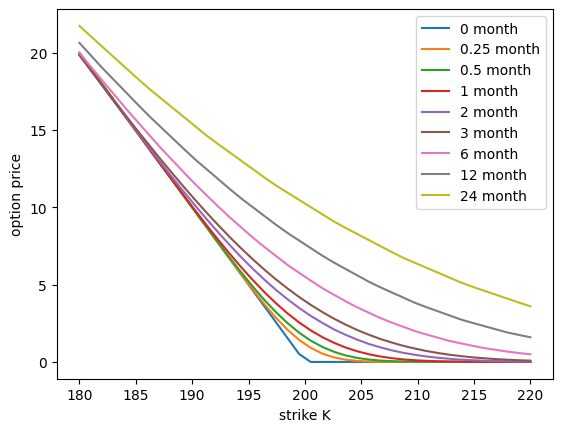

In [307]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, option_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

This looks like a reasonable payout graph for an option with the given parameters.

Another plot that can be made is given a strike and expiration time, how does the option price change as the volatility changes.

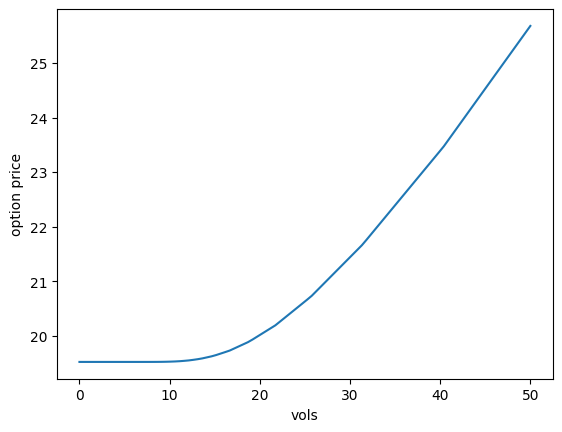

In [297]:
k = 180
exp_T = 1/2

vols = np.linspace(0, 50, 100)
prices = [price_option(call_option_payout(k), dist, u_0, v, exp_T, r) for v in vols]

plt.xlabel("vols")
plt.ylabel("option price")
plt.plot(vols, prices)
plt.show()

As we expected, we get a monotone increasing function. As the volatility of an underlying increases, so does the option price.

## Calculating Strike Vols

To calculate the implied volatility given a strike (and the corresponding payout function), the inverse of the function above essentially must be calculated. Unfortunately this cannot be easily solved analytically. Instead, it can be done computationally using the secant method since it doesn't require knowing the derivative of a function.

In [298]:
def calculate_implied_volatility(option_price, payout, normalized_distribution, current_underlying_price, expiration_time, interest_rate, max_vol_percent=0.5, epsilon=1e-2):
    def f(vol):
        return price_option(payout, normalized_distribution, current_underlying_price, vol, expiration_time, interest_rate) - option_price
    res = secant_method(f, 0, max_vol_percent * current_underlying_price, epsilon)
    return 0 if res is None else res

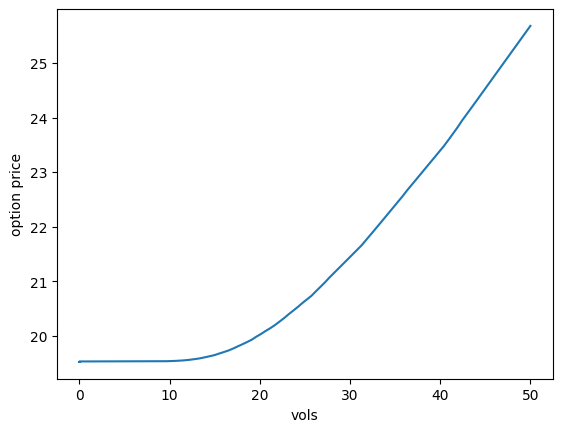

In [299]:
implied_vols = [calculate_implied_volatility(p, call_option_payout(k), dist, u_0, exp_T, r) for p in prices]

plt.xlabel("vols")
plt.ylabel("option price")
plt.plot(implied_vols, prices)
plt.show()

As we see we are able to recover the original vols given the option prices and construct the same graph as before. Now, lets see if we can use the option_prices matrix to get the volatility we used in the calculations further above.

In [326]:
implied_vols = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month vols . . .")
    for j in tqdm(range(len(ks))):
        implied_vols[i, j] = calculate_implied_volatility(option_prices[i, j], call_option_payout(ks[j]), dist, u_0, exp_t_month/12, r, epsilon=0.0001)

flattened_implied_vols = implied_vols.flatten()

print(flattened_implied_vols.mean())
print(flattened_implied_vols.std())

Calculating 0 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 39955.27it/s]


Calculating 0.25 month vols . . .


100%|██████████| 40/40 [00:01<00:00, 35.16it/s]


Calculating 0.5 month vols . . .


100%|██████████| 40/40 [00:03<00:00, 13.09it/s]


Calculating 1 month vols . . .


100%|██████████| 40/40 [00:02<00:00, 16.43it/s]


Calculating 2 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 128.18it/s]


Calculating 3 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 231.22it/s]


Calculating 6 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 350.88it/s]


Calculating 12 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 590.18it/s]


Calculating 24 month vols . . .


100%|██████████| 40/40 [00:00<00:00, 769.20it/s]

16.088900389677818
7.905391140214496


In [328]:
for i in range(len(exp_t_months)):
    print(implied_vols[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.41098098e-10 1.67144119e-09 1.60686720e-08 1.27727416e-07
 8.29366797e-07 5.87429539e-06 3.58853797e-05 1.86868903e-04
 8.11527681e-04 3.37613777e-03 1.94210676e+01 1.98408232e+01
 1.99493010e+01 1.99699136e+01 1.99881564e+01 1.99950091e+01
 1.99964383e+01 1.99992639e+01 1.99993942e+01 1.99991534e+01
 1.99991534e+01 1.99993942e+01 1.99992639e+01 1.99964383e+01
 1.99950091e+01 1.99881564e+01 1.99699136e+01 1.99493010e+01
 1.98408232e+01 1.94210676e+01 3.37613777e-03 8.11527681e-04
 1.86868903e-04 3.58853798e-05 5.87429532e-06 8.29366668e-07
 1.27727580e-07 1.60684887e-08 1.67214458e-09 1.40730636e-10]
[1.96649290e-05 7.24203241e-05 2.27515455e-04 6.41580311e-04
 1.74837142e-03 1.85682369e+01 1.95898726e+01 1.97910325e+01
 1.99389838e+01 1.99648571e+01 1.99788094e+01 1.99872032e+01
 1.99948192e+01 1.99968009e+01 1.99972690e+01 1.99983546e+01
 1.99994047e+01 1.9999

We notice that there is a decent bit of error in the calculation. Looking at implied vols, it looks like the expiration dates with small time till expiration do not seem to really contain the information of the volatility of the underlying. This is confirmed in the next few cells, where we are still able to approximately reconstruct the options prices using these implied vols (even when they are set to pretty much 0).

In [322]:
implied_prices = np.zeros((len(exp_t_months), len(ks)))

for i, exp_t_month in enumerate(exp_t_months):
    print(f"Calculating {exp_t_month} month option prices . . .")
    for j in tqdm(range(len(ks))):
        implied_prices[i, j] = price_option(call_option_payout(ks[j]), dist, u_0, implied_vols[i, j], exp_t_month/12, r)

Calculating 0 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 39974.31it/s]


Calculating 0.25 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 4444.30it/s]


Calculating 0.5 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5709.64it/s]


Calculating 1 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5712.75it/s]


Calculating 2 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 5708.67it/s]


Calculating 3 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6668.21it/s]


Calculating 6 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 8052.03it/s]


Calculating 12 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 7977.75it/s]


Calculating 24 month option prices . . .


100%|██████████| 40/40 [00:00<00:00, 6659.21it/s]


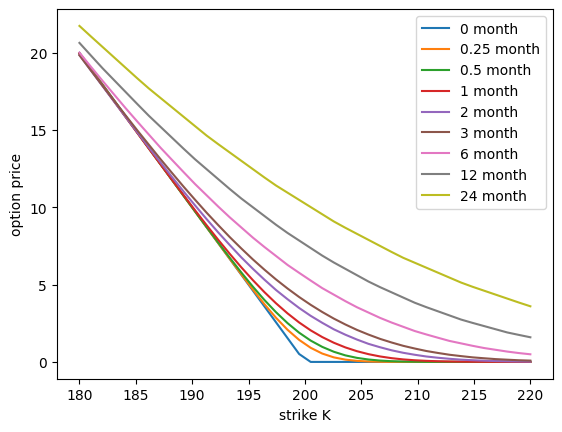

In [323]:
plt.xlabel("strike K")
plt.ylabel("option price")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, implied_prices[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

We can also print the strike vol curve (vols as a function of strike prices) and confirm that where the information of the volatility is stored. 

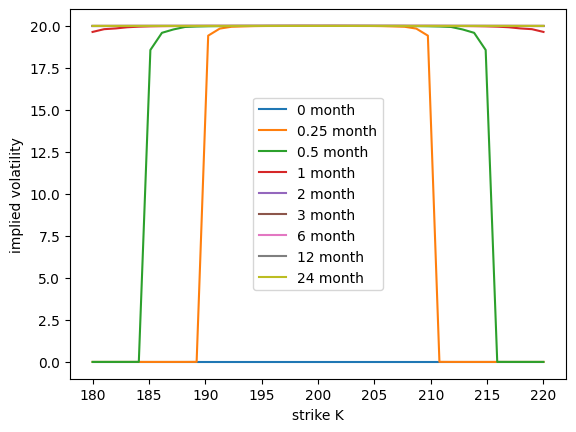

In [329]:
plt.xlabel("strike K")
plt.ylabel("implied volatility")

for i, exp_t_month in enumerate(exp_t_months):
    plt.plot(ks, implied_vols[i], label=f"{exp_t_month} month")

plt.legend()
plt.show()

Thus, a good estimator for the true volatility would just be to ignore any outliers (outside of 1 std from the mean), and then look at the results.

In [339]:
cleaned_implied_vols = flattened_implied_vols[np.abs(flattened_implied_vols - flattened_implied_vols.mean()) < flattened_implied_vols.std()]
print(cleaned_implied_vols.mean())
print(cleaned_implied_vols.std())

19.972378919452133
0.13691418761722077


This is a much better estimate for the volatility, but in practice we should just choose data that would contain the volatility information in the option price. To do so, we just pick strikes that are not too far from the current price and expiration times that are not too close to the current time.